# Fallback Table Metalearning ANALYSIS


In [81]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [82]:
# install.packages("pkgcond")

In [83]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [84]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


In [85]:
source('functions_metalearning.R')

In [86]:
source('functions_fallback.R')

In [87]:
# source('load_prep_data_expiry_2.R') #read in train test and predictions manually instead

# READ CSV's
# expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")
# expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
# expiry_df_test <- read.csv("../../data/output/datapull_20201116/expiry_df_test.csv")
# metametrics_df <- read.csv("../../data/output/datapull_20201116/expiry_metametrics_df.csv")
# expiry_df
# expiry_train_df 
# expiry_test_df 
# expiry_list
# expiry_train_list
# expiry_test_list

In [88]:
dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116'

modelDir='/home/jupyter/Domains_202003/data/output/models_20201104'

outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'

# Load predictions on new datapull

In [89]:
expiry_new_df <- readRDS(file.path(outputDir,"expiry_20200902_20201102_20201127"))
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")

expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))
expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

dim(expiry_new_df)
head(expiry_new_df)

Expiry data originally has 476586 rows and 476586 missing geo's.
... after intial merge on reseller & _country, expiry has 476586 rows and 476408 missing geo's.
... after secondary fill with _country, expiry has 476586 rows and 496 missing geo's.
... after manual tweaks with _country, expiry has 476586 rows and 71 missing geo's.


[1] 476586     33

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU


In [90]:
meta_preds <- read.csv(file.path(outputDir, 'meta_preds', 'meta_preds.csv'))
dim(meta_preds)
head(meta_preds)

[1] 535698     37

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


# Verify data integrity

In [91]:
meta_preds_tldre_count <- meta_preds %>% group_by(tld_registrar_index) %>% tally()
meta_preds_tldre_count %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<fct>,<int>
funalibaba,53324
spacealibaba,38716
sitegmo,34803
websitealibaba,25010
sitenamecheap,20337
sitereg.ru,13284


In [92]:
expiry_new_tldre_count <- expiry_new_df %>% group_by(tld_registrar_index) %>% tally() 
expiry_new_tldre_count$tld_registrar_index <- as.character(expiry_new_tldre_count$tld_registrar_index)
expiry_new_tldre_count %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<chr>,<int>
funalibaba,53324
sitegmo,34803
sitenamecheap,20337
spacealibaba,19358
sitereg.ru,13284
onlinego daddy,12936


In [93]:
join_tldre_count <- left_join(meta_preds_tldre_count, expiry_new_tldre_count,
           by='tld_registrar_index') 

join_tldre_count %>% arrange(desc(n.x)) %>% head()

tld_registrar_index,n.x,n.y
<chr>,<int>,<int>
funalibaba,53324,53324
spacealibaba,38716,19358
sitegmo,34803,34803
websitealibaba,25010,12505
sitenamecheap,20337,20337
sitereg.ru,13284,13284


In [94]:
join_tldre_count <- join_tldre_count %>% mutate(missing_preds =n.x-n.y)
join_tldre_count %>% arrange(desc(missing_preds)) %>% head()

tld_registrar_index,n.x,n.y,missing_preds
<chr>,<int>,<int>,<int>
spacealibaba,38716,19358,19358
websitealibaba,25010,12505,12505
storeshopify,3528,1764,1764
spacehostinger,1634,817,817
techdomain.com - registrar,1498,749,749
pwregway,1462,731,731


# Evaluate perfromance

In [95]:
fallback_lift <- chart_lift(pred_df=meta_preds,
                        dep_var = "renewal_status",
                        pred_var = "predicted") 

fallback_lift
calc_auc(lift_df=fallback_lift)

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,15926,0.3611502,3.611502
0.2,26312,0.5966711,2.983355
0.3,34056,0.7722799,2.574266
0.4,38378,0.8702889,2.175722
0.5,41118,0.9324232,1.864846
0.6,42562,0.9651685,1.608614
0.7,43121,0.9778448,1.396921
0.8,43349,0.9830151,1.228769
0.9,43517,0.9868248,1.096472


[1] 0.7945666

In [96]:
prop.table(table(meta_preds$renewal_status))


Not Renewd    Renewed 
0.91768123 0.08231877 

In [97]:
plot_multigains <- function (lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


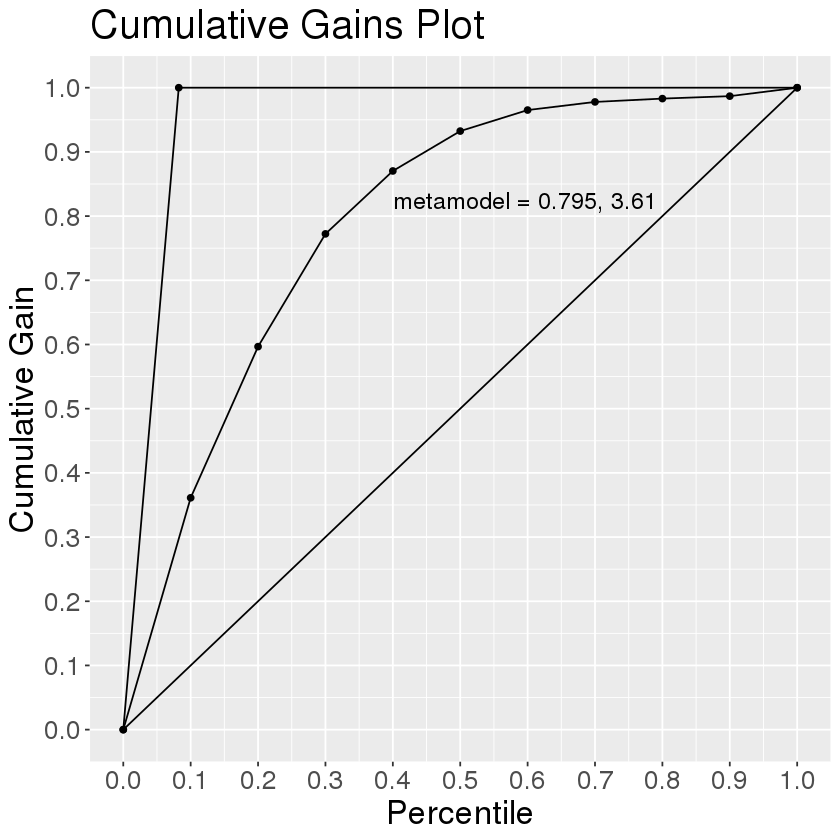

In [98]:
plot_multigains(lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) 

# FUP for Parag: 
## tabular (& visual) representation -- which registrars, which model (reseller priority level) 
## also performance metrics, see below (but that may be for the following Th)

### 1. Tabular

In [99]:
names(meta_preds)
head(meta_preds)

[1] "X"                    "reseller"             "reseller_country"    
 [4] "renewal_type"         "renewed_count"        "expiry_date"         
 [7] "creation_date"        "status"               "domain_id"           
[10] "domain"               "registrar"            "registrant_country"  
[13] "reg_period"           "reg_revenue"          "reg_arpt"            
[16] "renew_mbg"            "renewal_item_id"      "renew_type"          
[19] "autorenew_type"       "renewal_status"       "renew_date"          
[22] "renew_arpt"           "gibb_score"           "pattern"             
[25] "pattern_domain_count" "day_domains"          "sld_length"          
[28] "sld_type"             "sld_type2"            "tld"                 
[31] "region"               "log_reg_arpt"         "tld_registrar_index" 
[34] "reseller_geo"         "actual"               "predicted"           
[37] "model"

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [101]:
vis_df <- meta_preds
# add reseller priority columns to metalearning predictions
priorityLookup_df <- read.csv("/home/jupyter/Domains_202003/data/data_input/PredictiveModelAnalysis_ResellerPriorityList.csv")
names(priorityLookup_df) <- c("market","reseller","npv2020","priority")
priorityLookup_df$reseller <- tolower(priorityLookup_df$reseller)
vis_df$reseller <- tolower(vis_df$reseller)
vis_df <- merge(vis_df, priorityLookup_df, by="reseller", all.x=TRUE)



dim(vis_df)
head(vis_df)

[1] 535698     40

,reseller,X,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model,market,npv2020,priority
,<chr>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>,<int>
1,1&1 internet,73133,Germany,Subsequent,3,2020-10-02,2017-10-02,Active,53343383,genomission.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,8.58,genomission,2,77,11,l,11l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.7603850,preds_agg_rf_ALL,Europe,770943,1
2,1&1 internet,71319,Germany,Second,2,2020-09-12,2018-09-12,Active,76459334,revaaa.online,1&1 Internet,NA,1,25.0,25.0,0,336283329,renewal,NA,Renewed,2020-08-10,25,0.65,reaae,2,324,6,l,6l,online,Non China,3.2188758,online1&1 internet,EU,Renewed,0.6455068,preds_agg_rf_ALL,Europe,770943,1
3,1&1 internet,74160,Germany,FirstTime,1,2020-09-10,2019-09-10,Active,127850776,lickpussy.online,1&1 Internet,NA,1,0.6,0.6,0,345122893,auto-renewal,unrealized,Not Renewd,2020-09-10,25,2.65,lickpussy,1,75,9,l,9l,online,Non China,-0.5108256,online1&1 internet,EU,Not Renewd,0.5246619,preds_agg_rf_ALL,Europe,770943,1
4,1&1 internet,73152,Germany,Second,2,2020-09-20,2018-09-20,Active,76998309,graffitifresser.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,7.21,iegraffitifresser,2,125,15,l,15l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.5811250,preds_agg_rf_ALL,Europe,770943,1
5,1&1 internet,74180,Germany,FirstTime,1,2020-09-11,2019-09-11,Active,128299636,mensajes.online,1&1 Internet,NA,1,5.0,5.0,0,345442173,auto-renewal,realized,Renewed,2020-09-11,25,4.97,mensajes,1,91,8,l,8l,online,Non China,1.6094379,online1&1 internet,EU,Renewed,0.4517150,preds_agg_rf_ALL,Europe,770943,1
6,1&1 internet,73155,Germany,Second,2,2020-10-05,2018-10-05,Active,78370179,georgeshuot.online,1&1 Internet,NA,1,25.0,25.0,0,0,NA,NA,Not Renewd,NA,NA,3.03,georgeshuot,1,64,11,l,11l,online,Non China,3.2188758,online1&1 internet,EU,Not Renewd,0.7859175,preds_agg_rf_ALL,Europe,770943,1


In [102]:
# by tld-reseller
vis_df_01 <- vis_df %>% select(tld_registrar_index, model) %>% distinct()
dim(vis_df_01)
head(vis_df_01)

[1] 2049    2

,tld_registrar_index,model
,<fct>,<fct>
1,online1&1 internet,preds_agg_rf_ALL
2,site1&1 internet,preds_agg_rf_ALL
3,fun1&1 internet,preds_seg2_glm_ALL
4,tech1&1 internet,preds_agg_rf_ALL
5,space1&1 internet,preds_agg_rf_ALL
6,store1&1 internet,preds_agg_rf_ALL


In [103]:
write.csv(vis_df_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytldre.csv', row.names=FALSE)

In [104]:
# by reseller
vis_df_02 <- vis_df %>% select(reseller, model) %>% distinct()
vis_df_02_01 <- vis_df_02 %>%
  group_by(reseller, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_02_01)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,model,n,freq
<chr>,<fct>,<int>,<dbl>
1&1 internet,preds_agg_rf_ALL,1,0.50
1&1 internet,preds_seg2_glm_ALL,1,0.50
101 domain,preds_agg_rf_ALL,1,0.33
101 domain,preds_seg2_glm_ALL,1,0.33
101 domain,preds_seg2_glm_fb,1,0.33
10dencehispahard,preds_agg_rf_ALL,1,0.50


In [105]:
write.csv(vis_df_02_01, '../../data/output/deliv_20201210/20200902_20201008_model_byre_auc.csv', row.names=FALSE)

In [106]:
vis_df_02_02 <- vis_df_02 %>%
  group_by(reseller, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_02_02)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,model,n,freq
<chr>,<fct>,<int>,<dbl>
1&1 internet,preds_agg_rf_ALL,1,0.50
1&1 internet,preds_seg2_glm_ALL,1,0.50
101 domain,preds_agg_rf_ALL,1,0.33
101 domain,preds_seg2_glm_ALL,1,0.33
101 domain,preds_seg2_glm_fb,1,0.33
10dencehispahard,preds_agg_rf_ALL,1,0.50


In [107]:
write.csv(vis_df_02_02, '../../data/output/deliv_20201210/20200902_20201008_model_byre_l10.csv', row.names=FALSE)

In [108]:
# by tld
vis_df_03 <- vis_df %>% select(tld,model) 
vis_df_03_01 <- vis_df_03 %>%
  group_by(tld, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_03_01)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)



tld,model,n,freq
<fct>,<fct>,<int>,<dbl>
fun,preds_agg_rf_ALL,64057,0.95
fun,preds_seg2_glm_ALL,2994,0.04
fun,preds_seg2_glm_fb,382,0.01
host,preds_agg_rf_ALL,6851,0.88
host,preds_seg2_glm_ALL,864,0.11
host,preds_seg2_glm_fb,49,0.01


In [109]:
write.csv(vis_df_03_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytld_auc.csv', row.names=FALSE)

In [110]:
# by priority
vis_df_04 <- vis_df %>% select(priority, model)
vis_df_04_01 <- vis_df_04 %>%
  group_by(priority, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_04_01)

`summarise()` regrouping output by 'priority' (override with `.groups` argument)



priority,model,n,freq
<int>,<fct>,<int>,<dbl>
1,preds_agg_rf_ALL,349120,0.89
1,preds_seg2_glm_ALL,41102,0.11
1,preds_seg2_glm_fb,529,0.00
2,preds_agg_rf_ALL,43702,0.87
2,preds_seg2_glm_ALL,5609,0.11
2,preds_seg2_glm_fb,661,0.01


In [111]:
write.csv(vis_df_04_01, '../../data/output/deliv_20201210/20200902_20201008_model_bypri_auc.csv', row.names=FALSE)

In [112]:
# cross section graph of tld vs reseller and model (w/ shading) in the intersection: 
#    https://www.r-graph-gallery.com/79-levelplot-with-ggplot2.html
# by reseller:  percentage of each model assigned
# by tld:  percentage of each model assigned
# by priority: percentage of each model assigned

In [115]:
vis_sub <- vis_df %>% group_by(tld, reseller, model) %>% tally()
head(vis_sub)

tld,reseller,model,n
<fct>,<chr>,<fct>,<int>
fun,1&1 internet,preds_seg2_glm_ALL,18
fun,101 domain,preds_seg2_glm_ALL,1
fun,10dencehispahard,preds_seg2_glm_ALL,3
fun,1api,preds_agg_rf_ALL,2
fun,1api,preds_seg2_glm_ALL,2
fun,ab name isp,preds_seg2_glm_ALL,3


In [131]:
vis_sub$reseller <- factor(vis_sub$reseller, levels =unique(vis_sub$reseller[order(vis_sub$n)]))

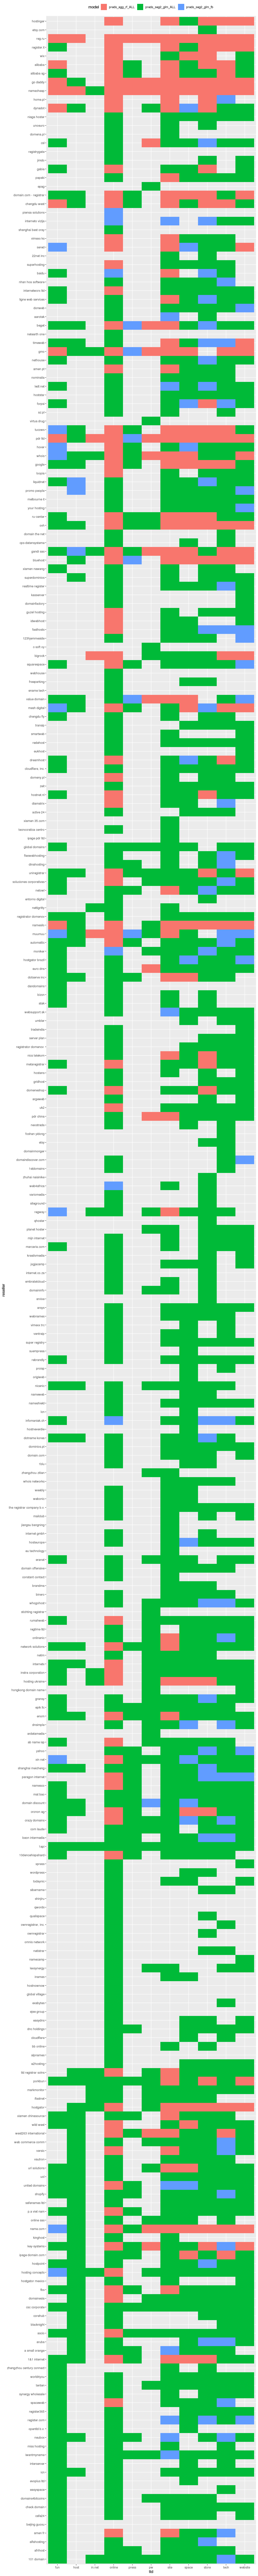

In [133]:
library(repr)
options(repr.plot.width=10, repr.plot.height=100)
ggplot(vis_sub , 
       aes(tld, reseller, fill=model)) + 
  geom_tile() + 
  theme(legend.position='top')
ggsave('../../data/output/deliv_20201210/20200902_20201008_plot.pdf', width=10, height= 40) #A4 size in inches

In [54]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")

# FUP for Parag: 
## table of predictions at domain level based on model assignment

In [31]:
head(meta_preds)

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [32]:
names(meta_preds)

[1] "X"                    "reseller"             "reseller_country"    
 [4] "renewal_type"         "renewed_count"        "expiry_date"         
 [7] "creation_date"        "status"               "domain_id"           
[10] "domain"               "registrar"            "registrant_country"  
[13] "reg_period"           "reg_revenue"          "reg_arpt"            
[16] "renew_mbg"            "renewal_item_id"      "renew_type"          
[19] "autorenew_type"       "renewal_status"       "renew_date"          
[22] "renew_arpt"           "gibb_score"           "pattern"             
[25] "pattern_domain_count" "day_domains"          "sld_length"          
[28] "sld_type"             "sld_type2"            "tld"                 
[31] "region"               "log_reg_arpt"         "tld_registrar_index" 
[34] "reseller_geo"         "actual"               "predicted"           
[37] "model"

In [35]:
meta_preds %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                      actual, 'model','predicted') %>% head()

,tld_registrar_index,reseller,tld,domain_id,domain,actual,model,predicted
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
1,fun1api,1API,fun,53188623,sla.fun,Not Renewd,preds_agg_rf_ALL,0.5988058
2,fun1api,1API,fun,78340684,rodzina.fun,Not Renewd,preds_agg_rf_ALL,0.8564813
3,funalibaba,Alibaba,fun,76434689,1-zhao.fun,Renewed,preds_agg_rf_ALL,0.1398346
4,funalibaba,Alibaba,fun,75994739,leafapp.fun,Renewed,preds_agg_rf_ALL,0.1979831
5,funalibaba,Alibaba,fun,77302744,icc.fun,Renewed,preds_agg_rf_ALL,0.2805935
6,funalibaba,Alibaba,fun,75791344,sgzx.fun,Renewed,preds_agg_rf_ALL,0.1995516


In [36]:
prop.table(table(meta_preds$model))


  preds_agg_rf_ALL preds_seg2_glm_ALL  preds_seg2_glm_fb 
       0.847587633        0.147667156        0.004745211 

In [37]:
dim(meta_preds)

[1] 535698     37

In [39]:
write.csv(meta_preds %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                      actual, 'model','predicted')  ,
         '../../data/output/deliv_20201210/20200902_20201008_preds.csv', row.names=FALSE)

In [40]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

# Performance Metrics

performance metrics on 3 diff levels (poss 4) - not in order of priority
- aggregate probabilities at the tld-reseller level... over day or month
- lift metric. what does the lift mean?
- inverse of the lift. below which probability level can we be sure that these domains be dropped (not renewed) the other end of the lift. from the bottom up. will help formulate retention strategy
- thresh-hold false positive or false negatives - determine what threshold will be good for which tld-registrar. kaybe at a tld-registrar level (MORE TIME, MORE THAN ANOTHER WEEK)
top 10 registrars - understanding of one 
accuracy - false positive, false negatives... across all tld-re... big tld-re's overpower the general metrics. how do we address this? we look at it at the tld=reseller level. small and large separately? at the priority level... high priority is high, volume is high
goal: to be accurate at the tld-reseller level. 

## aggregate probabilities at the tld-reseller level... over day or month

In [53]:
meta_preds$expiry_date <- as.Date(meta_preds$expiry_date)
str(meta_preds$expiry_date)
head(meta_preds)

 Date[1:535698], format: "2020-09-29" "2020-10-05" "2020-09-12" "2020-09-06" "2020-09-24" ...


,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<date>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [54]:
options(scipen=999)
library(lubridate)

agg_prob <- meta_preds %>% group_by(tld_registrar_index) %>% summarize(sum_pred = round(sum(predicted,4)), 
                                                                        sum_actl = sum(actual=='Renewed'), 
                                                                        count = length(actual))  %>% arrange(desc(count))
agg_prob_day <- meta_preds %>% group_by(tld_registrar_index, expiry_date) %>% summarize(sum_pred = round(sum(predicted,2)), 
                                                                        sum_actl = sum(actual=='Renewed'), 
                                                                        count = length(actual))  %>% arrange(desc(count))
agg_prob_month <- meta_preds %>% group_by(tld_registrar_index, month=floor_date(expiry_date, "month") ) %>% summarize(sum_pred = round(sum(predicted,2)), 
                                                                        sum_actl = sum(actual=='Renewed'), 
                                                                        count = length(actual))  %>% arrange(desc(count))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [57]:
write.csv(agg_prob ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob.csv', row.names=FALSE)
write.csv(agg_prob_day ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob_day.csv', row.names=FALSE)
write.csv(agg_prob_month ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob_month.csv', row.names=FALSE)

In [58]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

# lift metric. by tld-reseller

In [147]:
calc_lift <- function (pred_df,
                       P=0.1,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = TRUE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [148]:
chart_lift <- function (pred_df=first_renewal_model_test_predict,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction") {
  N <- 10  # total number of rows to preallocate--possibly an overestimate
  lift_df <- data.frame(P =rep(NA, N), 
                        actu_renwd2=rep(NA, N), 
                        gain=rep(NA, N), 
                        lift=rep(NA, N), 
                        stringsAsFactors=FALSE)          # you don't know levels yet
  actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
  
  i = 1
  for(P in seq(.1,1,length=10)){
    temp_df <- data.frame(pred_df)[c(dep_var,pred_var)]
    ttmp_df <- temp_df[order(temp_df[pred_var],decreasing = TRUE),][1:round(dim(temp_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    
    lift_df[i, ] <- list(P, actu_renwd2, gain, lift)
    i = i+1
  }
  return(lift_df)
}

In [232]:
tld_registrar_str='funkey-systems'
meta_preds %>% filter(tld_registrar_index==tld_registrar_str) %>% nrow()
chart_lift(meta_preds %>% filter(tld_registrar_index==tld_registrar_str), dep_var = "renewal_status", pred_var = "predicted")
calc_lift(meta_preds %>% filter(tld_registrar_index==tld_registrar_str), dep_var = "renewal_status", pred_var = "predicted")
lift_list[[tld_registrar_str]]
lift_bytldre %>% filter(tld_registrar_index==tld_registrar_str)

[1] 20

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,2,0.1666667,1.666667
0.2,3,0.2500000,1.250000
0.3,4,0.3333333,1.111111
0.4,5,0.4166667,1.041667
0.5,6,0.5000000,1.000000
0.6,8,0.6666667,1.111111
0.7,9,0.7500000,1.071429
0.8,10,0.8333333,1.041667
0.9,11,0.9166667,1.018519


[1] 1.666667

[1] 1.666667

tld_registrar_index,count,l10
<chr>,<int>,<dbl>
funkey-systems,20,1.666667


In [177]:
meta_preds_list <- split(meta_preds, meta_preds$tld_registrar_index)
lift_list <- lapply(meta_preds_list,calc_lift, dep_var = "renewal_status", pred_var = "predicted")
lift_list[[tld_registrar_str]]

[1] 0.8885017

In [211]:
# lift_v <- sapply(meta_preds_list,calc_lift, dep_var = "renewal_status", pred_var = "predicted")
# lift_v <- as.data.frame(lift_v)
# lift_v$tld_registrar_index <- rownames(lift_v)
rownames(lift_v) <- NULL
head(lift_v)

,lift_v,tld_registrar_index
,<dbl>,<chr>
1,0,fun1&1 internet
2,NaN,fun101 domain
3,NaN,fun10dencehispahard
4,NaN,fun1api
5,10,funab name isp
6,NaN,funafrihost


In [217]:
lift_bytldre <- left_join(lift_v, meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual)) ,
                     by='tld_registrar_index')
lift_bytldre <- lift_bytldre[c('tld_registrar_index', 'count', 'lift_v')] %>% rename(l10=lift_v) %>% arrange(desc(count))
head(lift_bytldre)

`summarise()` ungrouping output (override with `.groups` argument)



,tld_registrar_index,count,l10
,<chr>,<int>,<dbl>
1,funalibaba,53324,8.068182
2,spacealibaba,38716,5.694444
3,sitegmo,34803,9.275956
4,websitealibaba,25010,7.083333
5,sitenamecheap,20337,2.489451
6,sitereg.ru,13284,1.392405


In [218]:
write.csv(lift_bytldre ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_lift_bytldre.csv', row.names=FALSE)

In [219]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

## inverse of the lift. 
below which probability level can we be sure that these domains be dropped (not renewed) the other end of the lift. from the bottom up. will help formulate retention strategy

In [235]:
meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual), 
                                                           count_ren = sum(actual=='Renewed')) %>% arrange(desc(count_ren)) %>% 
 filter(count==200) %>% head()

`summarise()` ungrouping output (override with `.groups` argument)



tld_registrar_index,count,count_ren
<fct>,<int>,<int>
onlinehosteurope,200,136


In [242]:
# playing around with l10 calc..
# in the observations predicted to be most likely to renew (top 10%), .8 of them actually renew... compared to 68% over the whole data
# so the additional benefit of using the model as computed by lift@10% is .8/.68=1.17
test_df <- meta_preds_list[['onlinehosteurope']] %>% select(actual,predicted) %>% arrange(desc(predicted))
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_l10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_l10/rate_all
calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

[1] 0.68

[1] 0.8

[1] 1.176471

[1] 1.176471

In [244]:
# playing around with il10 calc..
# in the observations predicted to be least likely to renew (bottom 10%), half of them actually renew... compared to 68% over the whole data
# so inverse lift is 0.5/0.68=0.735
test_df <- meta_preds_list[['onlinehosteurope']] %>% select(actual,predicted) %>% arrange(predicted)
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_il10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_il10/rate_all
# calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

[1] 0.68

[1] 0.5

[1] 0.7352941

In [245]:
calc_ilift <- function (pred_df,
                       P=0.1,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = FALSE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [246]:
ilift_v <- sapply(meta_preds_list,calc_ilift, dep_var = "renewal_status", pred_var = "predicted")
ilift_v <- as.data.frame(ilift_v)
ilift_v$tld_registrar_index <- rownames(ilift_v)
rownames(ilift_v) <- NULL
head(ilift_v)

,ilift_v,tld_registrar_index
,<dbl>,<chr>
1,0,fun1&1 internet
2,NaN,fun101 domain
3,NaN,fun10dencehispahard
4,NaN,fun1api
5,0,funab name isp
6,NaN,funafrihost


In [247]:
ilift_v %>% filter(tld_registrar_index=='onlinehosteurope')

ilift_v,tld_registrar_index
<dbl>,<chr>
0.7352941,onlinehosteurope


In [248]:
ilift_bytldre <- left_join(ilift_v, meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual)) ,
                     by='tld_registrar_index')
ilift_bytldre <- ilift_bytldre[c('tld_registrar_index', 'count', 'ilift_v')] %>% rename(il10=ilift_v) %>% arrange(desc(count))
head(ilift_bytldre)

`summarise()` ungrouping output (override with `.groups` argument)



,tld_registrar_index,count,il10
,<chr>,<int>,<dbl>
1,funalibaba,53324,0.07575758
2,spacealibaba,38716,0.41666667
3,sitegmo,34803,0.00000000
4,websitealibaba,25010,1.04166667
5,sitenamecheap,20337,0.12658228
6,sitereg.ru,13284,0.18987342


In [249]:
write.csv(ilift_bytldre ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_ilift_bytldre.csv', row.names=FALSE)

In [250]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

In [251]:
# playing around with il10 calc..
# in the observations predicted to be least likely to renew (bottom 10%), half of them actually renew... compared to 68% over the whole data
# so inverse lift is 0.5/0.68=0.735
test_df <- meta_preds_list[['sitegmo']] %>% select(actual,predicted) %>% arrange(predicted)
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_il10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_il10/rate_all
# calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

[1] 0.02103267

[1] 0

[1] 0

In [134]:
meta_preds %>% filter(tld_registrar_index=='funab.name.isp')

X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>


In [137]:
chart_lift( meta_preds_list['funab.name.isp'], dep_var = "renewal_status", pred_var = "predicted") 

ERROR: Error in `[.data.frame`(data.frame(pred_df), c(dep_var, pred_var)): undefined columns selected
